In [137]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score



In [138]:
DIS = "/Users/davidhoffman/desktop/stocks_download/DIS_2006-01-01_to_2018-01-01.csv"
df = pd.read_csv(DIS, index_col="Date", parse_dates=True)

In [139]:
#Only keep closing price of the day
df.drop(['Open','High','Low'], axis = 1, inplace = True)
df.drop(['Name'], axis = 1, inplace = True)
df.drop(['Volume'], axis = 1, inplace = True)

In [140]:
#Perform Dicky Fuller test to test for stationarity
# Function taken from class lecture


def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )

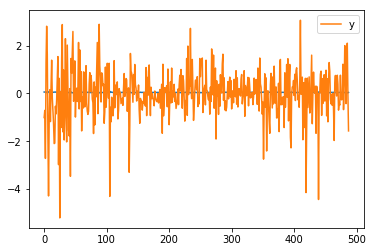

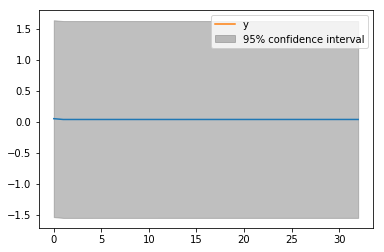

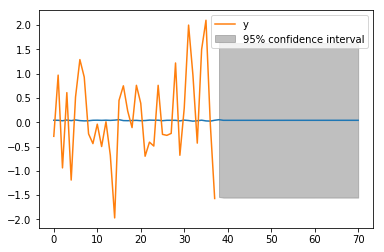

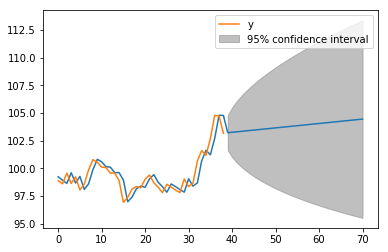

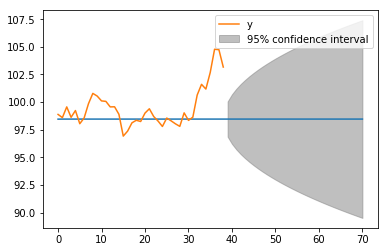

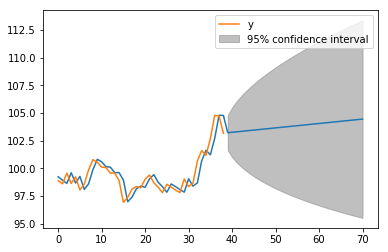

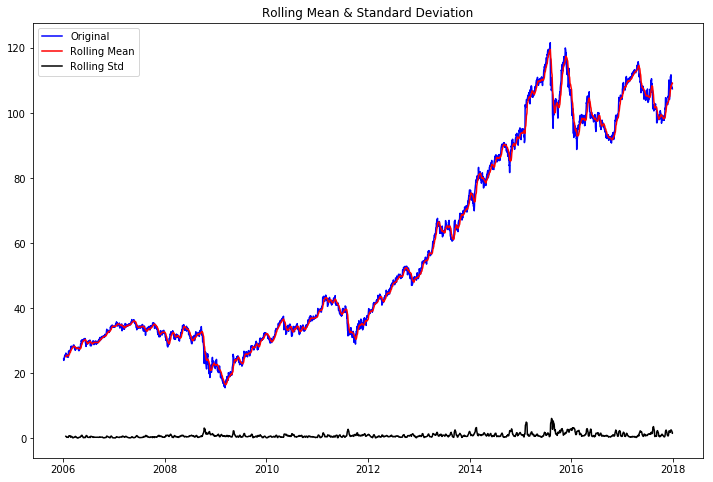

Results of Dickey-Fuller Test:
Test Statistic   -0.263906
p-value           0.930463
dtype: float64


In [141]:
#testing stationarity

test_stationarity(df.Close)

In [142]:
#High pvalue --> no stationarity
#Must get to a point of stationarity for the time series
#Will get the difference in my values
df['close_diff_1']=df.Close.diff()

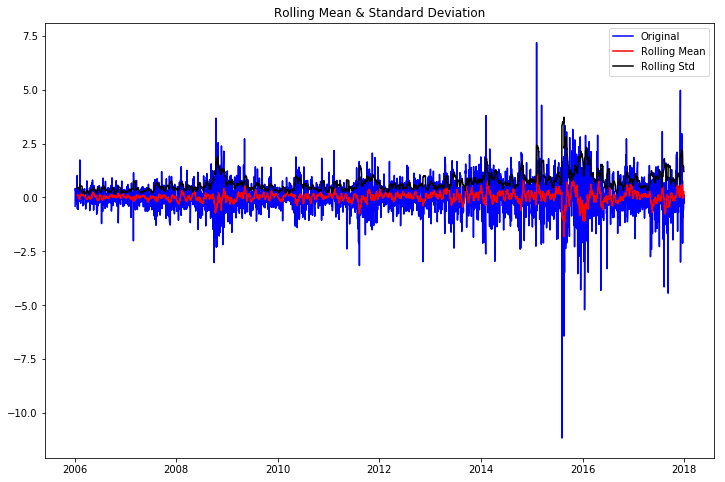

Results of Dickey-Fuller Test:
Test Statistic   -9.691806e+00
p-value           1.131262e-16
dtype: float64


In [143]:
#Testing for stationarity with my first differenced values 

test_stationarity(df.close_diff_1.dropna())

In [151]:
#Seperate into train and test

train = df.Close[:-31]
test = df.Close[len(train-1):]

In [152]:
#Difference the train set
train_diff = train.diff()

In [153]:
#fit model
ar1ma1 = ARIMA(train_diff.dropna().values, (1,1,1)).fit(disp=0)


/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [154]:
#predict out of sample month ---> test set

preds = ar1ma1.predict(start=len(train),end=len(train)+31)

/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [155]:
#Add predictions to the last value in train set
full_pred = train[len(train)-1]+np.cumsum(preds)

In [156]:
for i in range(31):
    print ("actual", test[i], "predicted", full_pred[i])
    print ("difference (pred - actual)", full_pred[i]-test[i])

actual 103.69 predicted 104.79264783564047
difference (pred - actual) 1.102647835640468
actual 103.6 predicted 104.77951795534113
difference (pred - actual) 1.1795179553411401
actual 103.44 predicted 104.77963285678109
difference (pred - actual) 1.339632856781094
actual 102.75 predicted 104.77964051611741
difference (pred - actual) 2.0296405161174107
actual 103.0 predicted 104.77964904378581
difference (pred - actual) 1.7796490437858097
actual 102.74 predicted 104.77965756442339
difference (pred - actual) 2.0396575644233934
actual 102.64 predicted 104.77966608511788
difference (pred - actual) 2.139666085117881
actual 102.79 predicted 104.77967460581192
difference (pred - actual) 1.9896746058119135
actual 103.41 predicted 104.77968312650597
difference (pred - actual) 1.3696831265059757
actual 105.24 predicted 104.77969164720001
difference (pred - actual) -0.4603083527999843
actual 104.82 predicted 104.77970016789405
difference (pred - actual) -0.04029983210594423
actual 105.25 predicted

In [150]:
#create function to predict next weeks prices
#Essentially putting together all the previous cells into one function

def price_preds(df,days, column = 'Close'):
    #df = dataframe
    #column = Close --> predicting closing price
    #days --> how many days do you want to predict
    
    #Seperate into train and test
    train = df.Close[:-days]
    test = df.Close[len(train)-1:]
    
    #Difference the train set
    train_diff = train.diff()
    
    #fit model
    ar1ma1 = ARIMA(train_diff.dropna().values, (1,1,1)).fit(disp=0)
    
    #predict out of sample month ---> test set
    preds = ar1ma1.predict(start=len(train), end=(len(train)+(days-1))

                           
    #Add predictions to the last value in train set
    full_preds = (train[len(train)-1]+np.cumsum(preds))
                               
    #Set date ticks for graphs
    date_ticks = test.index
    
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(date_ticks, test, lw=2, color='grey', ls='dashed',label='Actual')
    ax.plot(date_ticks, full_preds, lw=2, color='darkred',label='Predicted')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Actual vs predicted price")
    plt.legend()
    plt.show();


SyntaxError: invalid syntax (<ipython-input-150-a0dc77781c15>, line 24)

/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


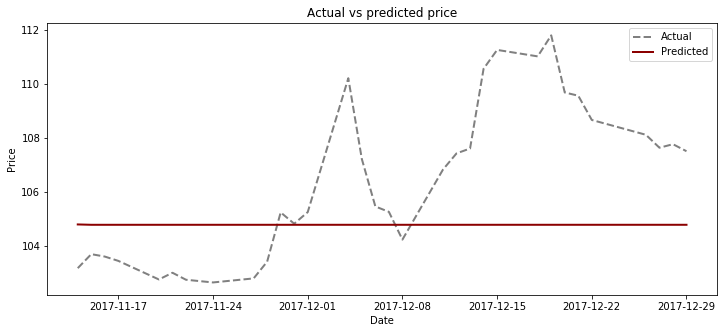

In [63]:
price_preds(df = df, days = 31, column = 'Close')

In [ ]:
def price_preds(df, column = Close):
    #Seperate into train and test
    train = df.Close[:-31]
    test = df.Close[len(train-1):]
    
    #Difference the train set
    train_diff = train.diff()
    
    #fit model
    ar1ma1 = ARIMA(train_diff.dropna().values, (1,1,1)).fit(disp=0)
    
    #predict out of sample month ---> test set
    preds = ar1ma1.predict(start=len(train),end=len(train)+31)

    #Add predictions to the last value in train set
    full_pred = train[len(train)-1]+np.cumsum(preds)